1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

In [2]:
train = pd.read_csv('train_case2.csv', delimiter=';')

In [3]:
train.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=['cardio']), train['cardio'], random_state=0)

In [5]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [6]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [7]:
classifiers = {r'LogisticRegression': Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),]),
    r'GradientBoosting': Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),]),
    r'RandomForest': Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),])
    }

2. при обучении моделей обязательно использовать кроссвалидацию

In [8]:
results = {}
for classifier_name, classifier in classifiers.items():
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print('{}: CV score is {}+-{}'.format(classifier_name, cv_score, cv_score_std))
    classifier.fit(X_train, y_train)
    results[classifier_name] = classifier.predict_proba(X_test)[:, 1]

LogisticRegression: CV score is 0.7867401104915408+-0.00852135511666111
GradientBoosting: CV score is 0.8025125910838183+-0.00707472977074522
RandomForest: CV score is 0.7734501681056019+-0.007171140345435727


3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)

In [9]:
metrics = {r'model': [], r'f-score': [], r'precision': [], r'recall': [], r'auc': []}
for classifier_name, result in results.items():
    precision, recall, thresholds = precision_recall_curve(y_test.values, result)
    fscore = 2*(precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    roc_auc = roc_auc_score(y_true=y_test, y_score=result)
    metrics[r'model'].append(classifier_name)
    metrics[r'f-score'].append(fscore[ix])
    metrics[r'precision'].append(precision[ix])
    metrics[r'recall'].append(recall[ix])
    metrics[r'auc'].append(fscore[ix])

In [10]:
metrics_df = pd.DataFrame(metrics)
metrics_df

,model,f-score,precision,recall,auc
0,LogisticRegression,0.730323,0.647431,0.837558,0.730323
1,GradientBoosting,0.740248,0.697848,0.788134,0.740248
2,RandomForest,0.718863,0.642669,0.815553,0.718863


4. сделать выводы о том, какая модель справилась с задачей лучше других

GradientBoosting справилась с задачей лучше других.

5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

In [11]:
def plot_roc_and_precision_recall_curves(fig, axes, model, y_test, y_score):
    axr, axp = axes
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    fpr_1, tpr_1, thresholds_1 = precision_recall_curve(y_test, y_score, pos_label=1)
    lw = 2
    axr.plot(fpr, tpr, lw=lw, label=model)
    axp.plot(fpr_1, tpr_1, lw=lw, label=model)
    axr.set_title('ROC curve')
    axp.set_title('Precision-Recall curve')
    axr.legend()
    axp.legend()
    fig.tight_layout(pad=0.1)

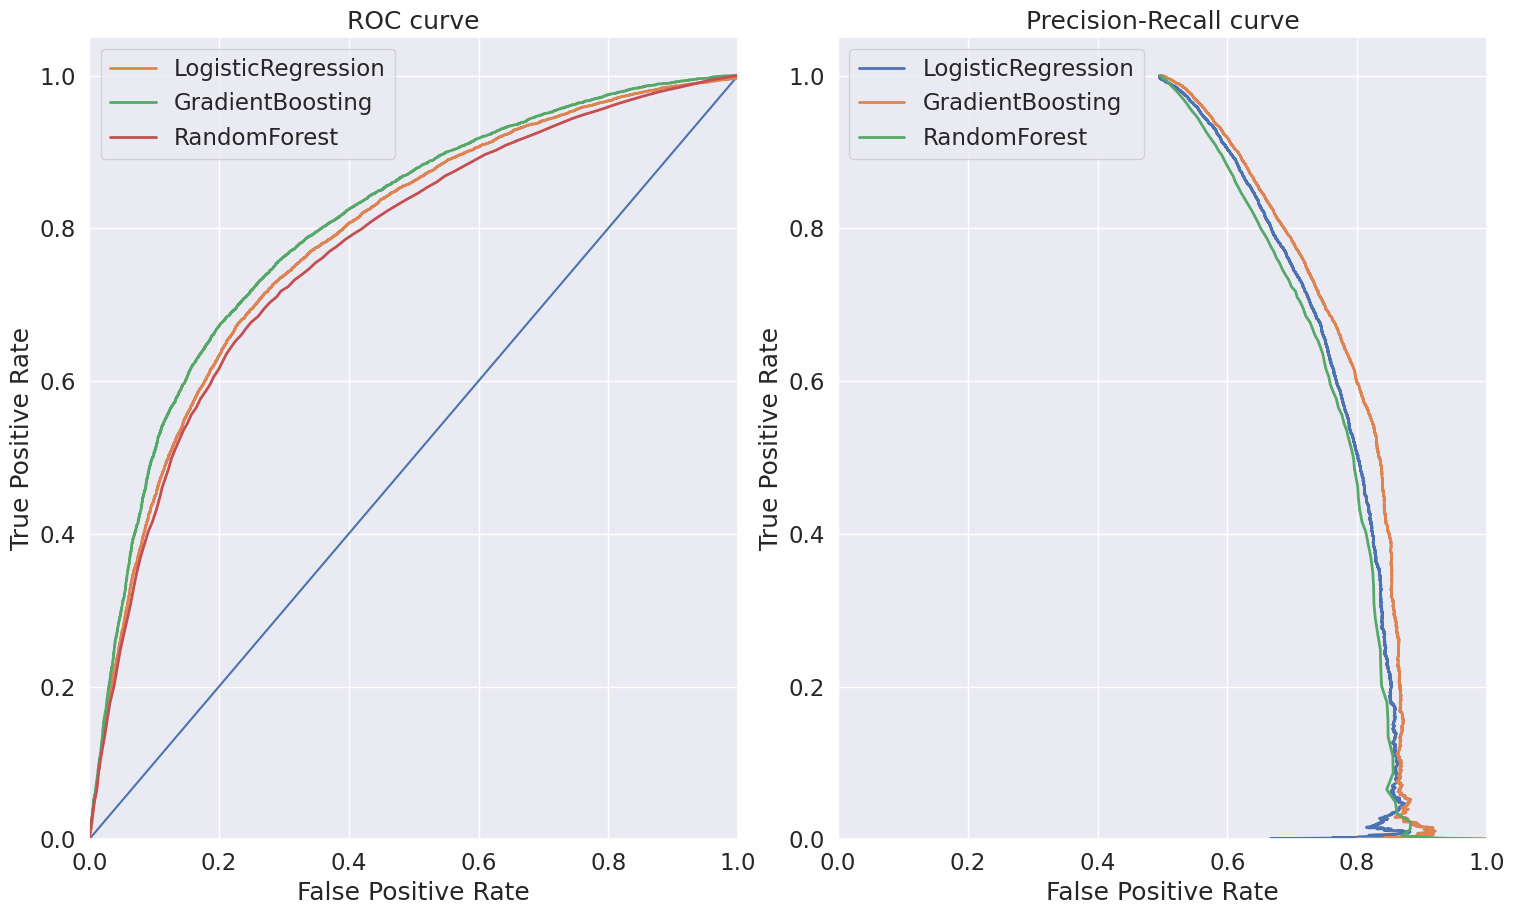

In [17]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")
fig, axes = plt.subplots(1, 2, figsize=(15, 9))
axes[0].plot([0, 1], [0, 1])
for ax in axes:
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
for classifier_name, result in results.items():
    plot_roc_and_precision_recall_curves(fig, axes, classifier_name, y_test, result)
plt.show()

В данной задаче нельзя допустить пропуска людей с заболеваниями сердца, поэтому вторая модель будет лучше.